It's highly recommended to run this ipynb file on Google Colab

In [2]:
!pip install ndjson

In [7]:
import ndjson
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import requests
import gdown

In [9]:
url = f"https://storage.googleapis.com/quickdraw_dataset/full/raw/smiley%20face.ndjson"
output = "data.ndjson"

gdown.download(url, output, quiet=False)

with open(output, "r") as f:
    data = ndjson.load(f)

Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/raw/smiley%20face.ndjson
To: /content/data.ndjson
100%|██████████| 335M/335M [00:04<00:00, 71.6MB/s]


In [10]:
def draw_image(strokes, size=28, padding=5):
    img = Image.new("L", (256, 256), color=0)
    draw = ImageDraw.Draw(img)

    for stroke in strokes:
        points = list(zip(stroke[0], stroke[1]))
        draw.line(points, fill=255, width=6)

    img = img.resize((size, size), Image.Resampling.LANCZOS)
    return np.array(img, dtype=np.uint8)


In [11]:
def draw_image_scaled(strokes, size=28, padding=6):
    img = Image.new("L", (256, 256), color=0)
    draw = ImageDraw.Draw(img)


    all_x = [x for stroke in strokes for x in stroke[0]]
    all_y = [y for stroke in strokes for y in stroke[1]]

    if not all_x or not all_y:
        return np.zeros((size, size), dtype=np.uint8)

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    scale = max(max_x - min_x, max_y - min_y) + 1e-6

    def scale_point(x, y):
        x = (x - min_x) / scale * (255 - 2 * padding) + padding
        y = (y - min_y) / scale * (255 - 2 * padding) + padding
        return x, y

    for stroke in strokes:
        points = [scale_point(x, y) for x, y in zip(stroke[0], stroke[1])]
        draw.line(points, fill=255, width=6)

    img = img.resize((size, size), Image.Resampling.LANCZOS)
    return np.array(img, dtype=np.uint8)


In [12]:
images = []
labels = []

for item in data:
    if item["recognized"]:
        img = draw_image_scaled(item["drawing"])
        if img.sum() < 30:
            continue
        images.append(img)
        labels.append(item["word"])

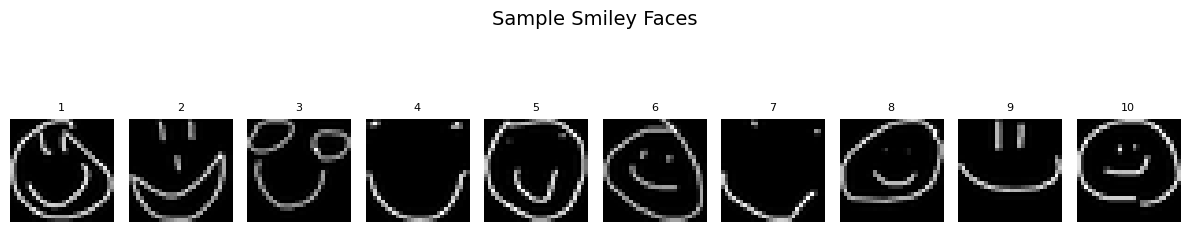

In [13]:
plt.figure(figsize=(12, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(f"{i+1}", fontsize=8)

plt.suptitle("Sample Smiley Faces", fontsize=14)
plt.tight_layout()
plt.show()


DCGAN

In [ ]:
class SmileyDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.data = torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 127.5 - 1.0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


smiley_dataset = SmileyDataset(images)
train_loader = DataLoader(smiley_dataset, batch_size=64, shuffle=True)


/tmp/ipython-input-16-1803816902.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.data = torch.tensor(images, dtype=torch.float32).unsqueeze(1) / 127.5 - 1.0


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Hyperparameters and Initializatuion

In [ ]:
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


Train the DCGAN

[Epoch 1/50] Loss D: 0.1725, Loss G: 4.8993
[Epoch 2/50] Loss D: 0.1125, Loss G: 3.6268
[Epoch 3/50] Loss D: 0.1524, Loss G: 4.4136
[Epoch 4/50] Loss D: 0.0864, Loss G: 4.6769
[Epoch 5/50] Loss D: 0.0414, Loss G: 6.1832
[Epoch 6/50] Loss D: 0.0249, Loss G: 6.2422
[Epoch 7/50] Loss D: 0.0773, Loss G: 6.0396
[Epoch 8/50] Loss D: 0.0608, Loss G: 6.0233
[Epoch 9/50] Loss D: 0.0297, Loss G: 6.9427
[Epoch 10/50] Loss D: 0.0433, Loss G: 6.0950


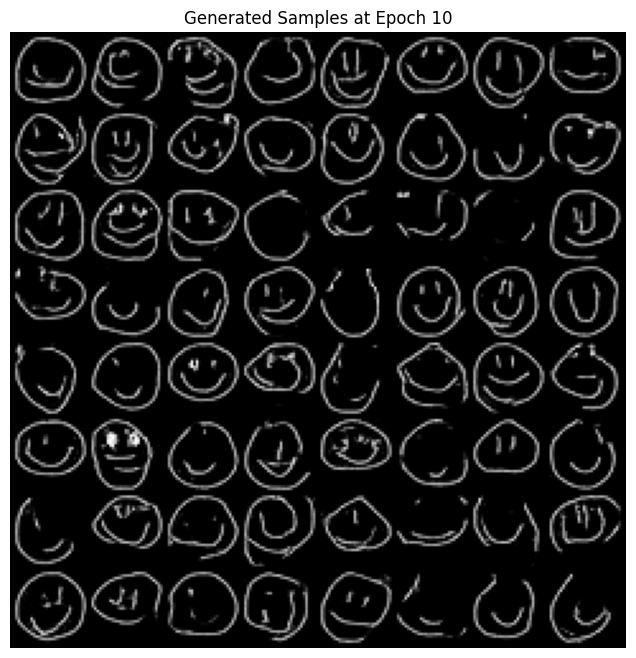

[Epoch 11/50] Loss D: 0.0378, Loss G: 5.2877
[Epoch 12/50] Loss D: 0.0569, Loss G: 5.7338
[Epoch 13/50] Loss D: 0.0680, Loss G: 5.6626
[Epoch 14/50] Loss D: 0.0291, Loss G: 5.7014
[Epoch 15/50] Loss D: 0.0605, Loss G: 5.9862
[Epoch 16/50] Loss D: 0.0452, Loss G: 5.6343
[Epoch 17/50] Loss D: 0.0274, Loss G: 7.0184
[Epoch 18/50] Loss D: 0.0130, Loss G: 6.8281
[Epoch 19/50] Loss D: 0.0396, Loss G: 7.1245
[Epoch 20/50] Loss D: 0.1245, Loss G: 4.7074


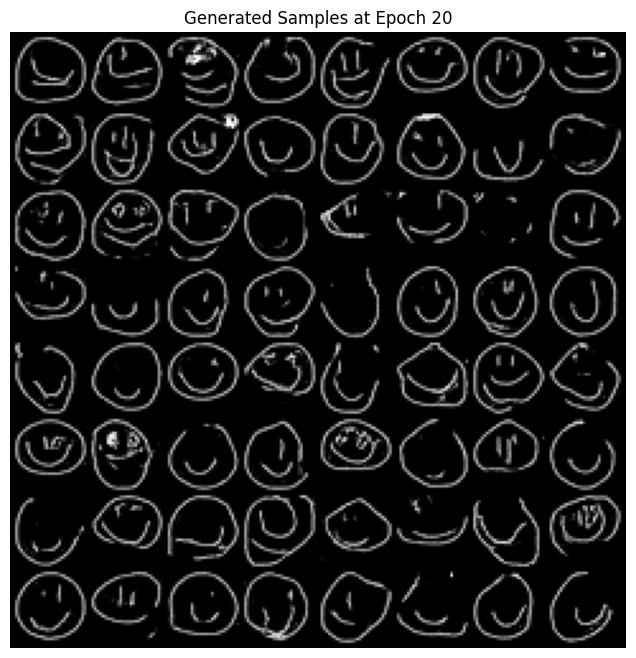

[Epoch 21/50] Loss D: 0.0399, Loss G: 6.4728
[Epoch 22/50] Loss D: 0.0107, Loss G: 6.9548
[Epoch 23/50] Loss D: 0.0219, Loss G: 6.9762
[Epoch 24/50] Loss D: 0.0574, Loss G: 5.5156
[Epoch 25/50] Loss D: 0.0233, Loss G: 7.0385
[Epoch 26/50] Loss D: 0.0502, Loss G: 6.6424
[Epoch 27/50] Loss D: 0.0179, Loss G: 6.5314
[Epoch 28/50] Loss D: 0.0295, Loss G: 8.2319
[Epoch 29/50] Loss D: 0.0046, Loss G: 7.4564
[Epoch 30/50] Loss D: 0.0075, Loss G: 7.9754


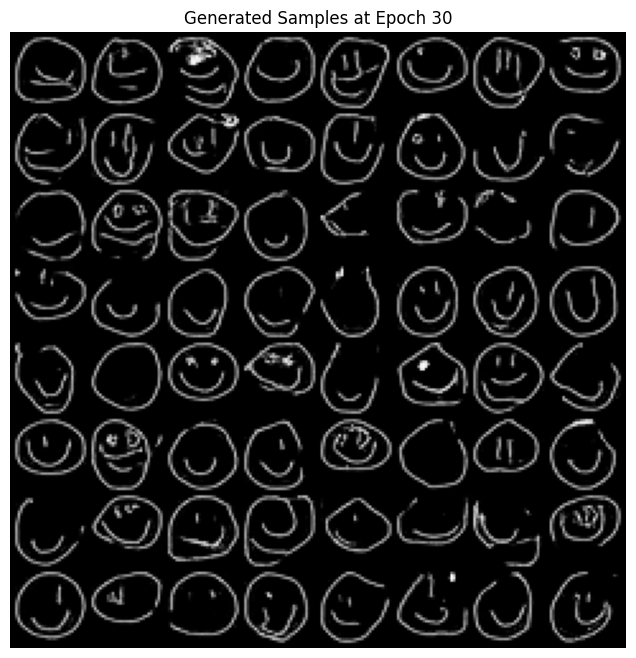

[Epoch 31/50] Loss D: 0.0099, Loss G: 7.7966
[Epoch 32/50] Loss D: 0.0569, Loss G: 6.9795
[Epoch 33/50] Loss D: 0.0202, Loss G: 6.9414
[Epoch 34/50] Loss D: 0.0341, Loss G: 7.6540
[Epoch 35/50] Loss D: 0.0286, Loss G: 7.5731
[Epoch 36/50] Loss D: 0.0196, Loss G: 7.3701
[Epoch 37/50] Loss D: 0.0345, Loss G: 7.1254
[Epoch 38/50] Loss D: 0.0213, Loss G: 6.5310
[Epoch 39/50] Loss D: 0.0114, Loss G: 7.3353
[Epoch 40/50] Loss D: 0.0302, Loss G: 6.3576


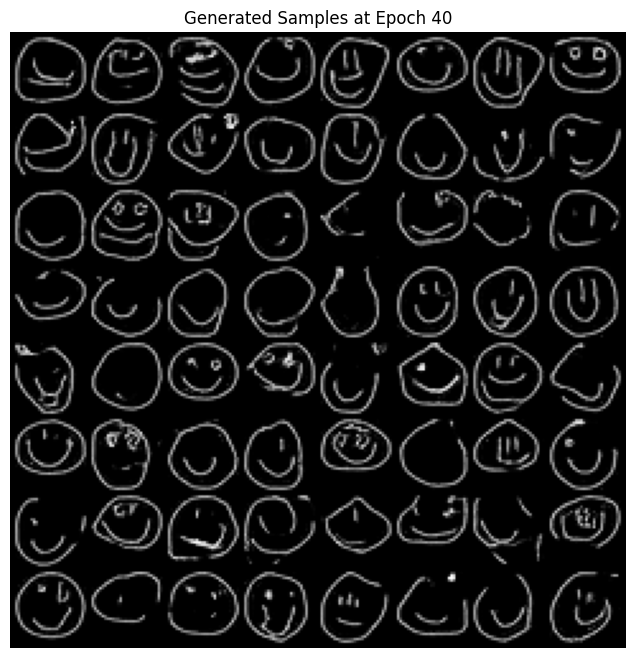

[Epoch 41/50] Loss D: 0.0139, Loss G: 7.5006
[Epoch 42/50] Loss D: 0.0277, Loss G: 6.4656
[Epoch 43/50] Loss D: 0.0336, Loss G: 6.1072
[Epoch 44/50] Loss D: 0.0214, Loss G: 7.8848
[Epoch 45/50] Loss D: 0.0283, Loss G: 7.7283
[Epoch 46/50] Loss D: 0.0570, Loss G: 6.3877
[Epoch 47/50] Loss D: 0.0197, Loss G: 7.0294
[Epoch 48/50] Loss D: 0.0209, Loss G: 6.4107
[Epoch 49/50] Loss D: 0.0821, Loss G: 8.4819
[Epoch 50/50] Loss D: 0.0568, Loss G: 6.6978


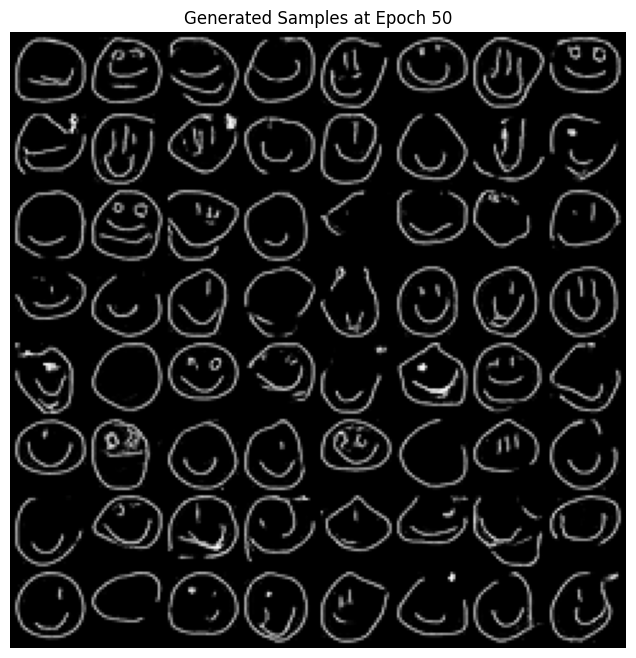

In [ ]:
epochs = 50
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(epochs):
    for i, real_imgs in enumerate(train_loader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_labels = torch.ones(real_imgs.size(0), 1, device=device)
        output_real = discriminator(real_imgs)
        loss_real = criterion(output_real, real_labels)

        # Fake images
        noise = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)
        output_fake = discriminator(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Fool the discriminator
        output = discriminator(fake_imgs)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Save sample outputs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_sample = generator(fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake_sample, padding=2, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
        plt.title(f"Generated Samples at Epoch {epoch+1}")
        plt.axis('off')
        plt.show()


Real vs Fake

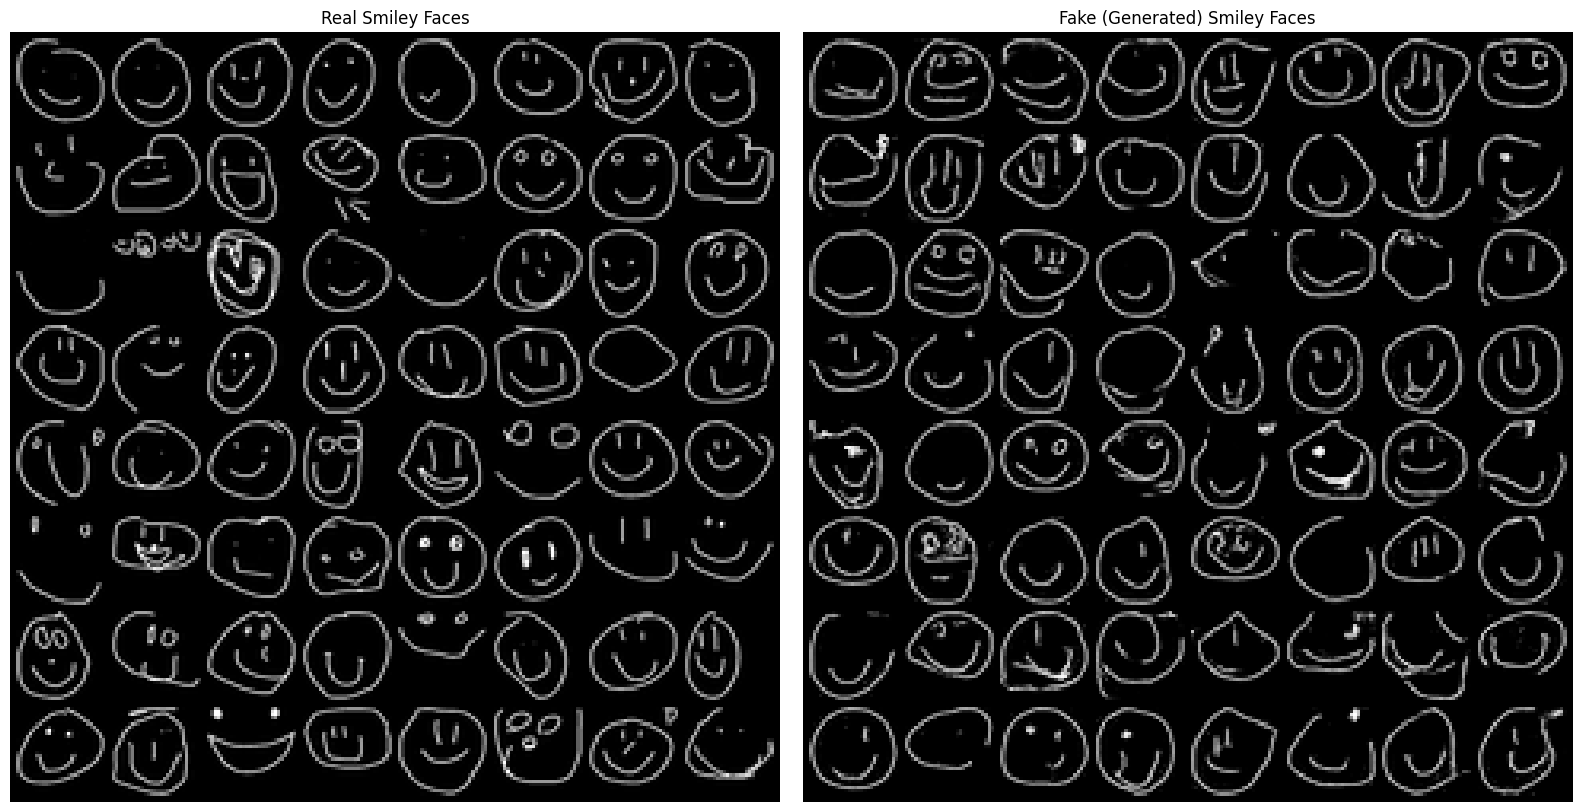

In [ ]:
# fake images from fixed noise
generator.eval()
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Real images
real_images = next(iter(train_loader))


grid_real = vutils.make_grid(real_images[:64], padding=2, normalize=True)
grid_fake = vutils.make_grid(fake_images[:64], padding=2, normalize=True)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(grid_real.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("Real Smiley Faces")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grid_fake.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("Fake (Generated) Smiley Faces")
plt.axis('off')

plt.tight_layout()
plt.show()
